# Direct Linear Transform (Tsai's Method)

## Import Modules

See [Python module tutorial](https://www.programiz.com/python-programming/modules)
See [Python regular packages](https://docs.python.org/3/reference/import.html#regular-packages)

In [1]:
import numpy as np
import scipy.linalg as linalg
import cv2
import matplotlib.pyplot as plt

import mae6292.tools as mae6292
from mae6292.imshow import cv2_imshow
import importlib

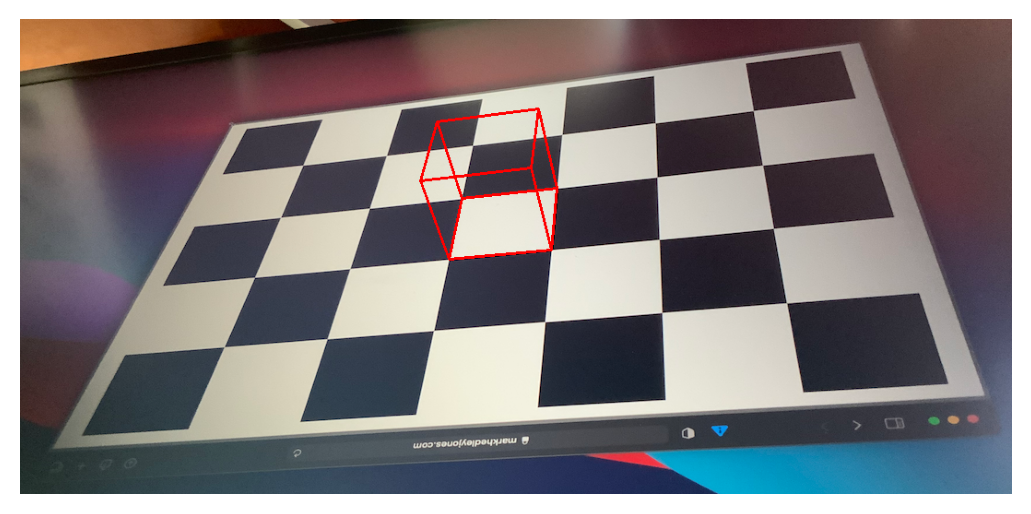

In [2]:
img = cv2.imread('../../HW2/img_cube.png')

cv2_imshow(img)

## Load Data from HW2

We load data from the results of HW#2, saved by the command

`np.savez('HW2.npz', P = vertices, p = M@vertices, K_cv = K, R_cv = R, T_cv = T, M_cv=M)`

In [3]:
np.set_printoptions(precision=5)

with np.load('HW2.npz') as data:
    P = data['P']
    p = data['p']
    K_cv = data['K_cv']
    R_cv = data['R_cv']
    T_cv = data['T_cv']
    M_cv = data['M_cv']

print(K_cv)
# print(R_cv)
# print(T_cv)

print(P)
print(p)

[[1.04100e+03 0.00000e+00 5.08037e+02]
 [0.00000e+00 9.78426e+02 3.06474e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
[[ 2.  3.  3.  2.  2.  3.  3.  2.]
 [ 1.  1.  2.  2.  1.  1.  2.  2.]
 [ 0.  0.  0.  0. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]
[[4739.99508 5633.59199 5166.67051 4273.0736  4169.68327 5063.28018
  4596.35869 3702.76178]
 [1926.45812 1772.03797 2240.76596 2395.18611 1027.74152  873.32137
  1342.04936 1496.46951]
 [   9.89487    9.66665    8.96039    9.1886     9.22471    8.9965
     8.29023    8.51845]]


## Calibration with Tsai's Method

Define $Q\in\Re^{2n\times 12}$ using 
* [np.kron()](https://numpy.org/doc/stable/reference/generated/numpy.kron.html)
* [np.append()](https://numpy.org/doc/stable/reference/generated/numpy.append.html)

In [4]:
n = P.shape[1]
p_uv = p[0:2,:]/p[2,:] # dehomonize into [u,v]

print("p", p.T)
print("p# _uv", p_uv.T)

Q = np.empty((0, 12))
for i in range(n):
    Qi_0 = np.array([ [1,0, -p_uv[0,i]], [0, 1, -p_uv[1,i]]] )
    Qi = np.kron(Qi_0, P[:,i].T)
    Q = np.append(Q, Qi, axis=0)

print(Q.shape)


p [[4739.99508 1926.45812    9.89487]
 [5633.59199 1772.03797    9.66665]
 [5166.67051 2240.76596    8.96039]
 [4273.0736  2395.18611    9.1886 ]
 [4169.68327 1027.74152    9.22471]
 [5063.28018  873.32137    8.9965 ]
 [4596.35869 1342.04936    8.29023]
 [3702.76178 1496.46951    8.51845]]
p# _uv [[479.03581 194.6927 ]
 [582.78626 183.31455]
 [576.61243 250.07469]
 [465.04073 260.6693 ]
 [452.01237 111.41179]
 [562.80576  97.07349]
 [554.43067 161.88322]
 [434.67576 175.67401]]
(16, 12)


Recover instrinsic and extrinsic parameters with

* [scipy.linalg,svd()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html)
* [scipy.linalg.rq()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.rq.html)
* [scipy.linalg,solve()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html)
* [np.diag()](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)
* [np.sign()](https://numpy.org/doc/stable/reference/generated/numpy.sign.html)
* [np.average()](https://numpy.org/doc/stable/reference/generated/numpy.average.html)

In [5]:
# 1. Find M_tilde using SVD

U, S, VT = linalg.svd(Q)
M_tilde =VT.T[:,-1].reshape(3,4)
# print(M_tilde / M_cv) # M is determined up to scale

# 2. RQ factorization to find K_tilde and R

K_tilde, R = linalg.rq(M_tilde[:,0:3])


# 3. Resolve the ambiguity of RQ factorization
D = np.diag( np.sign(np.diag(K_tilde)) )

print('D = ', D)

K_tilde  = K_tilde @ D 
R = D@R

# print('K_tilde = ', K_tilde)

# 4. Find T
T = linalg.solve(K_tilde, M_tilde[:,-1]).reshape(3,1)

# 5. 6. Recover scale

s = 1/K_tilde[2,2]
K = s*K_tilde
M = s*M_tilde

# 7. Resolve sign ambiguity
if linalg.det(R) < 0:
    R = -R
    T = -T
    M = -M

print('K_err =', linalg.norm(K-K_cv))
print('R_err =', linalg.norm(R-R_cv))
print('T_err =', linalg.norm(T-T_cv))
print('M_err =', linalg.norm(M-M_cv))

D =  [[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
K_err = 8.187336174442549e-10
R_err = 9.141202330784802e-13
T_err = 8.213228718920114e-12
M_err = 1.2005350356330725e-09


The above codes are saved as a function `mae6292.calibrateCamera_Tsai()`

In [6]:
K, R, T, M = mae6292.calibrateCamera_Tsai(p, P)

print(K)
# print(K_cv)
print(R)
print(T)
print(M)

[[1.04100e+03 8.93875e-11 5.08037e+02]
 [0.00000e+00 9.78426e+02 3.06474e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
[[ 0.96978 -0.10385  0.2208 ]
 [-0.08634  0.70029  0.70862]
 [-0.22821 -0.70627  0.67016]]
[[-2.11135]
 [-1.65806]
 [11.05756]]
[[ 8.93597e+02 -4.66921e+02  5.70312e+02  3.41972e+03]
 [-1.54420e+02  4.68728e+02  8.98717e+02  1.76657e+03]
 [-2.28214e-01 -7.06265e-01  6.70155e-01  1.10576e+01]]


## Reconstruct the 3D Scene

Now, we are going to reconstruct the 3D scene. In `mae6292.tools` there is a code to generate a wire frame camera model for given `(R,T)`, and also another code to generate chessboard for given checker size and (x,y) coordinates of the upper left corner.

We further visualize the corners detected, and a patch of square.


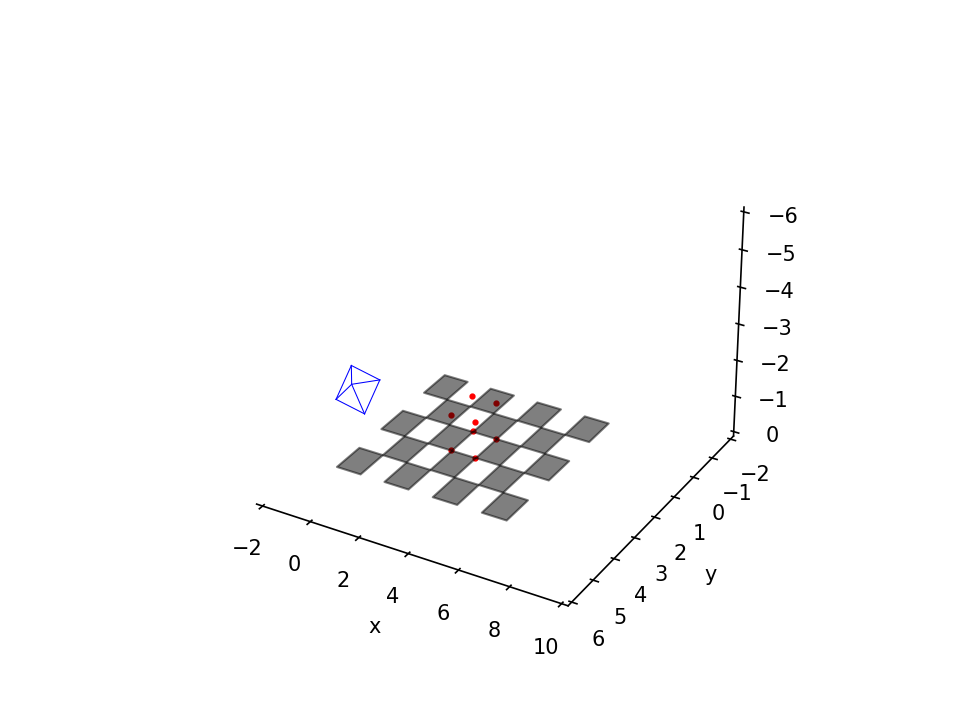

In [7]:
# %matplotlib notebook
# %matplotlib inline
%matplotlib widget
from mpl_toolkits import mplot3d

camera = mae6292.WireFrameCamera()
fig, ax = camera.draw(R,T)
# ax.axis('equal')
ax.invert_yaxis()
ax.invert_zaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

#  change the axis limit if needed
ax.axes.set_xlim3d(left=-2, right=10)
ax.axes.set_ylim3d(bottom=6, top=-2) 
ax.axes.set_zlim3d(bottom=0, top=-6) 

# # draw chessboard
chessboard = mae6292.ChessBoard((6,4), (-1,-1))
chessboard.draw(ax)

# draw corners
P_W = P[0:3,:]/P[3,:]
ax.plot(P_W[0,:],P_W[1,:],P_W[2,:],'o',markersize=2,c='r')

# # # view_init(elev=None, azim=None)
# # # ax.view_init(30, -80)